In [1]:
import klein_funcs as kf
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import torch, os

In [2]:
expr = kf.load_npz("../weinreb_inputs/counts_matrix_in_vitro.npz")
genes = kf.load_genes("../weinreb_inputs/gene_names_in_vitro.txt")
highly_variable_genes = kf.filter_genes(expr)
cell_cycle_genes = [['Ube2c',
                    'Hmgb2',
                    'Hmgn2',
                    'Tuba1b', 
                    'Ccnb1', 
                    'Tubb5', 
                    'Top2a', 
                    'Tubb4b']]
non_cell_cycle_idx = kf.remove_corr_genes(expr, gene_list=genes, exclude_corr_genes_list=cell_cycle_genes, test_gene_idx=highly_variable_genes, min_corr=0.1)
non_cell_cycle_idx = non_cell_cycle_idx[0:2447]
# perform filtering
expr = expr[:, non_cell_cycle_idx]
use_genes = [genes[i] for i in non_cell_cycle_idx]

In [3]:
meta = pd.read_csv("../weinreb_inputs/cell_metadata_in_vitro.txt", sep='\t')
annot_df = pd.DataFrame(meta['Annotation'].unique()).reset_index()
annot_df.columns = ['numeric_annotation', 'Annotation']
meta = meta.reset_index().merge(annot_df, how="left").drop('index', axis=1)
meta.head()

,Time point,Population,Annotation,Well,numeric_annotation
0,6.0,LK,undiff,2,0
1,6.0,LK,undiff,2,0
2,6.0,LK,Monocyte,2,1
3,6.0,LK,Neutrophil,2,2
4,6.0,LK,undiff,2,0


In [4]:
x = expr.todense()
y = meta['Time point'].values.astype(int)

In [5]:
ix_tr = meta['Time point'] != 4
ix_te = meta['Time point'] == 4

x_tr = x[ix_tr]
x_te = x[ix_te]
y_tr = y[ix_tr]
y_te = y[ix_te]

meta_tr = meta.loc[ix_tr]
meta_te = meta.loc[ix_te]

In [6]:
import numpy as np
import sklearn.preprocessing
import sklearn.decomposition
import umap

scaler = sklearn.preprocessing.StandardScaler()
pca = sklearn.decomposition.PCA(n_components = 50)
umap_reducer = umap.UMAP(n_components = 2, metric = 'euclidean', n_neighbors = 30)

In [9]:
x_tr = scaler.fit_transform(x_tr)
xp_tr = pca.fit_transform(x_tr)
xu_tr = umap_reducer.fit_transform(xp_tr)

x_te = scaler.transform(x_te)
xp_te = pca.transform(x_te)
xu_te = umap_reducer.transform(xp_te)

In [10]:
annot_order = list(meta_tr['Annotation'].value_counts().sort_values(ascending = False).index)
annot_order

['undiff',
 'Neutrophil',
 'Monocyte',
 'Baso',
 'Mast',
 'Meg',
 'Erythroid',
 'Eos',
 'Lymphoid',
 'Ccr7_DC',
 'pDC']

/home/mvinyard/.anaconda3/envs/sdq/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/mvinyard/.anaconda3/envs/sdq/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/mvinyard/.anaconda3/envs/sdq/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

<AxesSubplot:title={'center':'Day 6: Train'}>

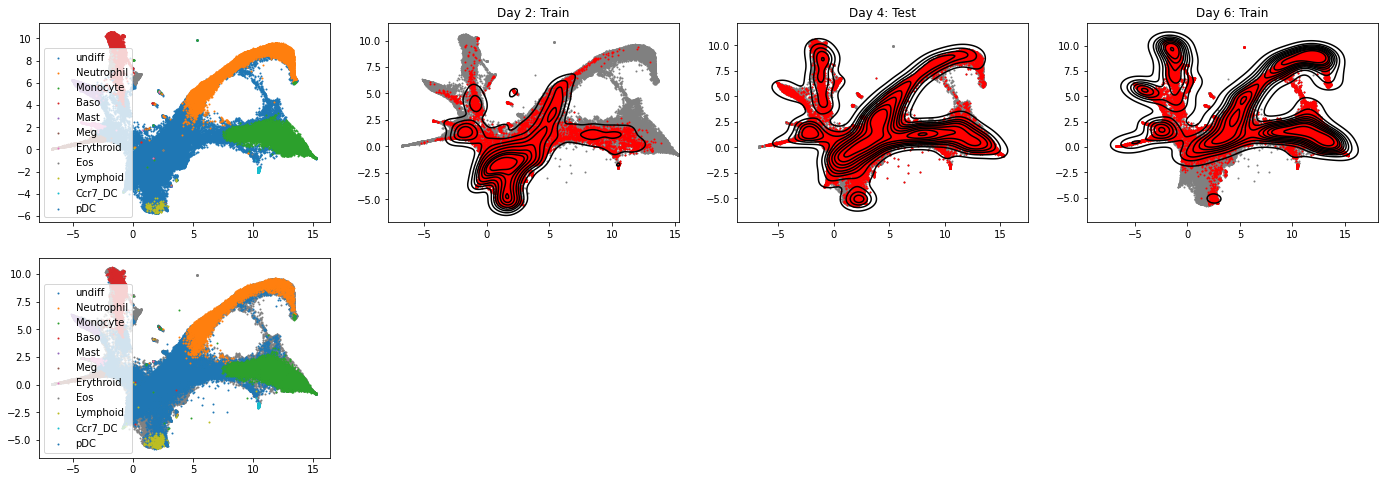

In [39]:
import vinplots 
import seaborn as sns

fig = vinplots.build.Plot()
fig.construct(nplots=5, ncols=4)
for a in annot_order: 
    px = meta_tr['Annotation'] == a
    fig.AxesDict[0][0].scatter(xu_tr[px, 0], xu_tr[px, 1], s = 1, label = a)
fig.AxesDict[0][0].legend()

fig.AxesDict[1][0].scatter(xu_tr[:,0], xu_tr[:,1], s = 1, color = 'gray')
for a in annot_order:
    px = meta_te['Annotation'] == a
    fig.AxesDict[1][0].scatter(xu_te[px, 0], xu_te[px, 1], s = 1, label = a)
fig.AxesDict[1][0].legend()

fig.AxesDict[0][1].scatter(xu_tr[:,0], xu_tr[:,1], s = 1, color = 'gray')
fig.AxesDict[0][1].scatter(xu_te[:,0], xu_te[:,1], s = 1, color = 'gray')
fig.AxesDict[0][1].set_title("Day 2: Train")
px = y_tr == 2
fig.AxesDict[0][1].scatter(xu_tr[px,0], xu_tr[px, 1], color = 'red', s = 1)
sns.kdeplot(xu_tr[px,0], xu_tr[px, 1], color = 'k', ax=fig.AxesDict[0][1])


fig.AxesDict[0][2].scatter(xu_tr[:,0], xu_tr[:,1], s = 1, color = 'gray')
fig.AxesDict[0][2].scatter(xu_te[:,0], xu_te[:,1], s = 1, color = 'gray')
fig.AxesDict[0][2].set_title("Day 4: Test")
px = y_te == 4
fig.AxesDict[0][2].scatter(xu_te[px,0], xu_te[px, 1], color = 'red', s = 1)
sns.kdeplot(xu_te[px,0], xu_te[px, 1], color = 'k', ax=fig.AxesDict[0][2])


fig.AxesDict[0][3].scatter(xu_tr[:,0], xu_tr[:,1], s = 1, color = 'gray')
fig.AxesDict[0][3].scatter(xu_te[:,0], xu_te[:,1], s = 1, color = 'gray')
fig.AxesDict[0][3].set_title("Day 6: Train")
px = y_tr == 6
fig.AxesDict[0][3].scatter(xu_tr[px,0], xu_tr[px, 1], color = 'red', s = 1)
sns.kdeplot(xu_tr[px,0], xu_tr[px, 1], color = 'k', ax=fig.AxesDict[0][3])

In [13]:
x_l = [x_tr[y_tr == 2,], x_te[y_te == 4,], x_tr[y_tr == 6,]]
xp_l = [xp_tr[y_tr == 2,], xp_te[y_te == 4,], xp_tr[y_tr == 6,]]
xu_l = [xu_tr[y_tr == 2,], xu_te[y_te == 4,], xu_tr[y_tr == 6,]]

x_l = [torch.from_numpy(a).float() for a in x_l]
xp_l = [torch.from_numpy(a).float() for a in xp_l]
xu_l = [torch.from_numpy(a).float() for a in xu_l]

In [15]:
# os.mkdir("notebook_data")
torch.save({
    'meta': meta, 
    'x': x_l, 
    'xp': xp_l, 
    'xu': xu_l, 
    'y': [2, 4, 6], 
}, "./notebook_data/Klein2020_impute.pt")

### Write adata

- We'll make sure to save the **`pca`** transformer. 

In [16]:
import torch
import scipy.sparse
import anndata as a

data_path = "./notebook_data/Klein2020_impute.pt"
data = torch.load(data_path)
data.keys()

dict_keys(['meta', 'x', 'xp', 'xu', 'y'])

In [17]:
adata = a.AnnData(scipy.sparse.csr_matrix(torch.concat([data['x'][0], data['x'][1], data['x'][2]]).numpy()))
adata.obs = data['meta']
adata.obsm['X_pca'] = torch.concat([data['xp'][0], data['xp'][1], data['xp'][2]]).numpy()
adata.obsm['X_umap'] = torch.concat([data['xu'][0], data['xu'][1], data['xu'][2]]).numpy()
adata.uns['t'] = data['y']

/home/mvinyard/.anaconda3/envs/sdq/lib/python3.9/site-packages/anndata/_core/anndata.py:801: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [20]:
adata.obs['train'] = adata.obs['Time point'] != 4
adata.obs['test'] = adata.obs['Time point'] == 4

In [35]:
import pickle
pickle.dump(pca, open("adata.holdout.d4.pca", 'wb'))
pickle.dump(umap_reducer, open("adata.holdout.d4.umap", 'wb'))

In [38]:
adata.write_h5ad("adata.holdout.d4.h5ad")